<a href="https://colab.research.google.com/github/jiananwu72/LuFeO3Detect/blob/main/LuFeO3/LFOWindowingAutomated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pyNSID sidpy atomap nanonispy gwyfile pyTEMlib wget ipympl importlib
!pip install numpy==1.26.4

In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive


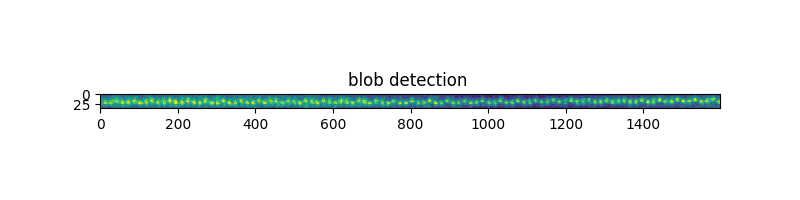

In [54]:
import skimage
import hyperspy.api as hs

s = hs.load('/content/drive/MyDrive/Data/LFO/HAADF_01.dm3')
s_cropped = s.isig[350:-100, 295:330]

image = s_cropped

fig1, ax = plt.subplots(1, 1,figsize=(8,2), sharex=True, sharey=True)
plt.title("blob detection ")
plt.imshow(image, interpolation='nearest', vmax=np.median(np.array(image))+3*np.std(np.array(image)))

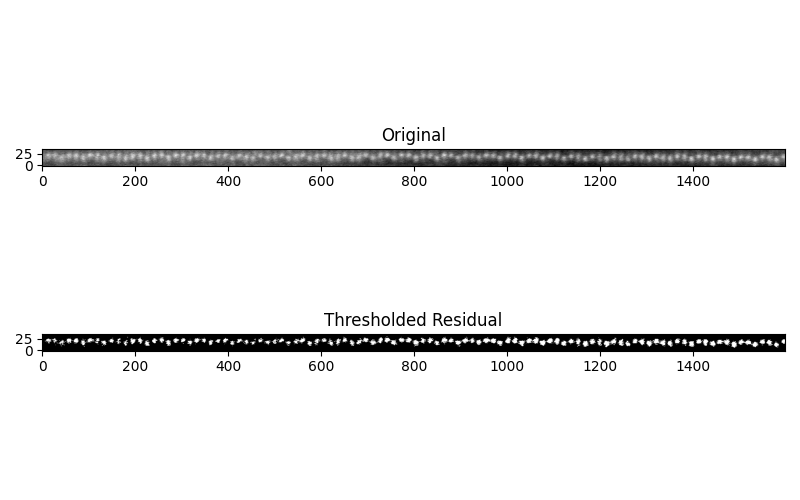

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter
from skimage.filters import median, threshold_yen
from skimage.morphology import disk

strip = image.data
col_median = np.median(strip, axis=0)


# bg1 = gaussian_filter(col_median, sigma=50)
# flat = strip - bg1[np.newaxis, :]
bg1 = median(strip, disk(20))         # tune radius for better performance; needs parameter tuning, so I will leave it here now.
flat = strip - bg1

th = threshold_yen(flat)
mask = flat > th

fig, axes = plt.subplots(2,1, figsize=(8,5))
axes[0].imshow(image, cmap='gray', origin='lower')
axes[0].set_title("Original")
axes[1].imshow(mask, cmap='gray', origin='lower')
axes[1].set_title("Thresholded Residual")
# axes[2].plot(col_median, label='raw median')
# axes[2].plot(bg1[:, ],     label='smoothed bg')
# axes[2].legend()
# axes[2].set_title("1D background")
plt.tight_layout()
plt.show()

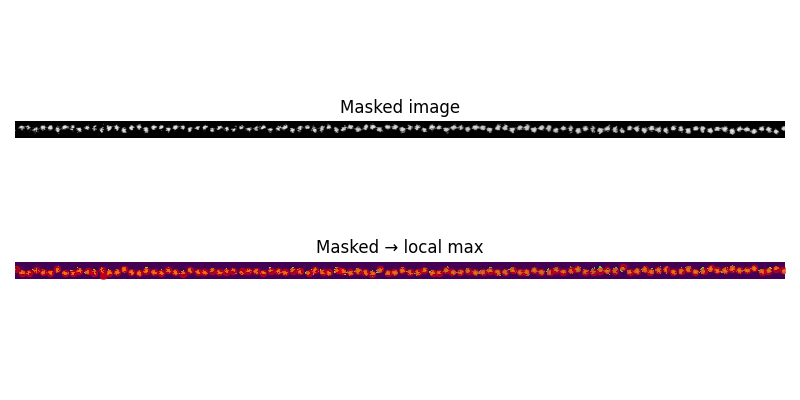

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

masked_img = image.data.copy()
masked_img[~mask] = 0

min_dist = 0.12 # adjust this by more experiments
scale_x = image.axes_manager['x'].scale
min_dist = int(min_dist/scale_x)
foot = np.ones((11, 11), dtype=bool)

atom_positions = peak_local_max(
    masked_img,
    min_distance=min_dist,
    threshold_abs=0,
    footprint=foot,
    exclude_border=False
)

y_peaks, x_peaks = atom_positions[:,0], atom_positions[:,1]
fig1, ax = plt.subplots(2, 1,figsize=(8,4))
ax[0].imshow(masked_img, cmap='gray', origin='lower')
ax[0].set_title("Masked image")
ax[1].imshow(masked_img, interpolation='nearest', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
ax[1].scatter(x_peaks, y_peaks, c='r', s=20, alpha = .5)
ax[1].set_title("Masked → local max")
for a in ax: a.axis('off')
plt.tight_layout()
plt.show()


In [71]:
import pyTEMlib.atom_tools
atom_radius = 5

sym = pyTEMlib.atom_tools.atom_refine(masked_img, atom_positions, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])

using radius  5 pixels


  0%|          | 0/108 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pyTEMlib/probe_tools.py:17: RuntimeWarning: invalid value encountered in divide
  probe = g / g.sum() * intensity
/usr/local/lib/python3.11/dist-packages/pyTEMlib/atom_tools.py:195: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  [pout, _] = optimization.leastsq(gauss_difference, guess, args=area)


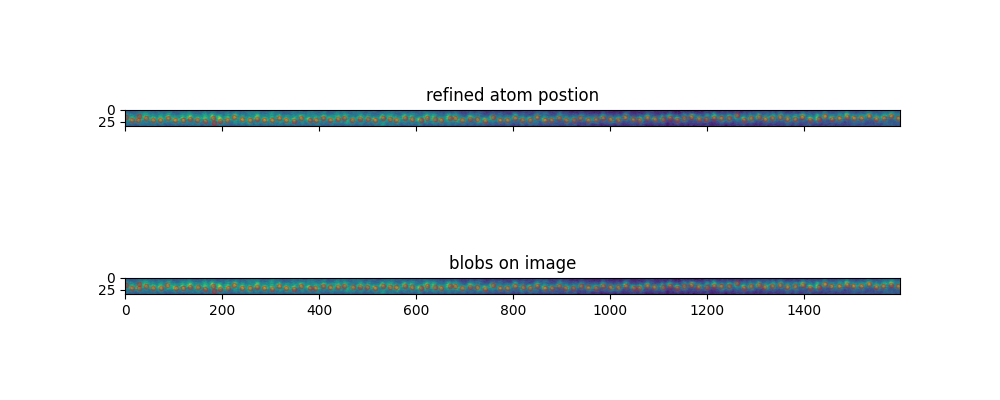

In [72]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True, sharey=True)
ax[0].imshow(image.T)
ax[0].scatter(refined_atoms[:,1],refined_atoms[:,0],  s=10, alpha = 0.3, color = 'red')
ax[0].set_title('refined atom postion')
ax[1].imshow(image.T)
ax[1].scatter(atom_positions[:, 1], atom_positions[:, 0], c='r', s=10, alpha = .3);
ax[1].set_title('blobs on image');

In [ ]:
atoms = refined_atoms[refined_atoms[:, 1].argsort()]
# atoms = atoms[:-1] #temporary fix

imagearr = np.array(image)
H, W = imagearr.shape

radius = 2

# Prepare a list to collect all 3×3 patches and keep track of valid indices
patches = []
valid_indices = []
masked_atoms = atoms

for idx in range(atoms.shape[0]):
    y, x = atoms[idx]
    cx = int(round(x))
    cy = int(round(y))

    if (cx - radius < 0) or (cy - radius < 0) or (cx + radius >= W) or (cy + radius >= H):
        mask = ~((masked_atoms[:,0] == y) & (masked_atoms[:,1] == x))
        masked_atoms = masked_atoms[mask]
        continue

    patch = imagearr[cy - radius : cy + radius + 1,
                     cx - radius : cx + radius + 1]

    patches.append(patch)
    valid_indices.append(idx)

# Convert the list of patches into a single NumPy array of shape (N_valid, 3, 3)
if len(patches) > 0:
    patches_array = np.stack(patches)
else:
    patches_array = np.empty((0, radius*2 + 1, radius*2 + 1))

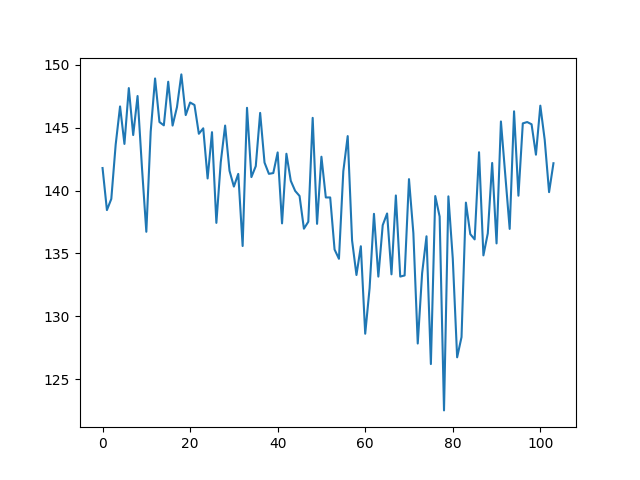

In [ ]:
sums = []
for i in range(len(patches_array)):
    sums.append(np.sum(np.array(patches_array[i])))

plt.figure()
# plt.hist(sums, bins=20);
plt.plot(sums);

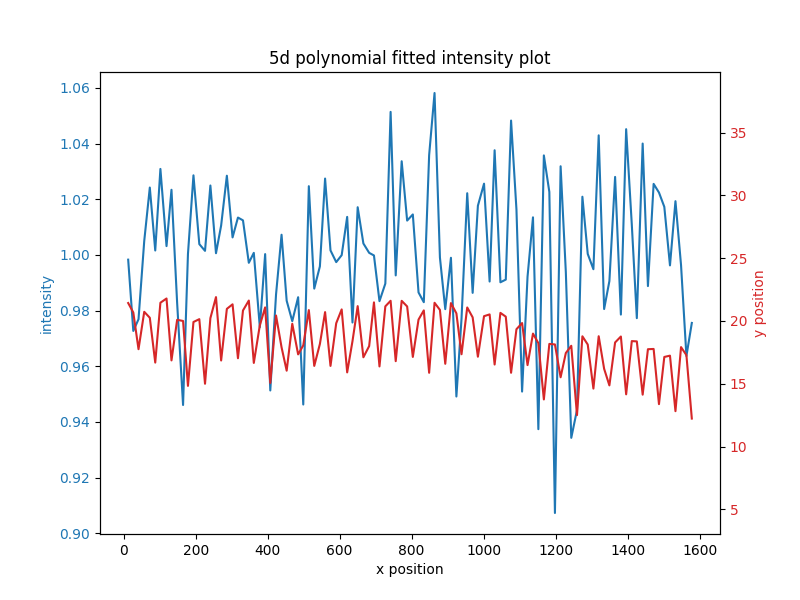

In [ ]:
x_loc = masked_atoms[:, 1]
y_loc = masked_atoms[:, 0]
coeffs = np.polyfit(x_loc, sums, deg=5)
I_bg_poly = np.polyval(coeffs, x_loc)

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot(x_loc, sums/I_bg_poly, color='tab:blue', label='intensity')
ax1.set_xlabel('x position')
ax1.set_ylabel('intensity', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(x_loc, y_loc, color='tab:red', label='y position')
ax2.set_ylabel('y position', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ymin, ymax = y_loc.min(), y_loc.max()
ymin = ymin - (ymax-ymin)*0.95
ymax = ymax + (ymax-ymin)*0.95
ax2.set_ylim(ymin, ymax)

plt.title("5d polynomial fitted intensity plot")
plt.show()

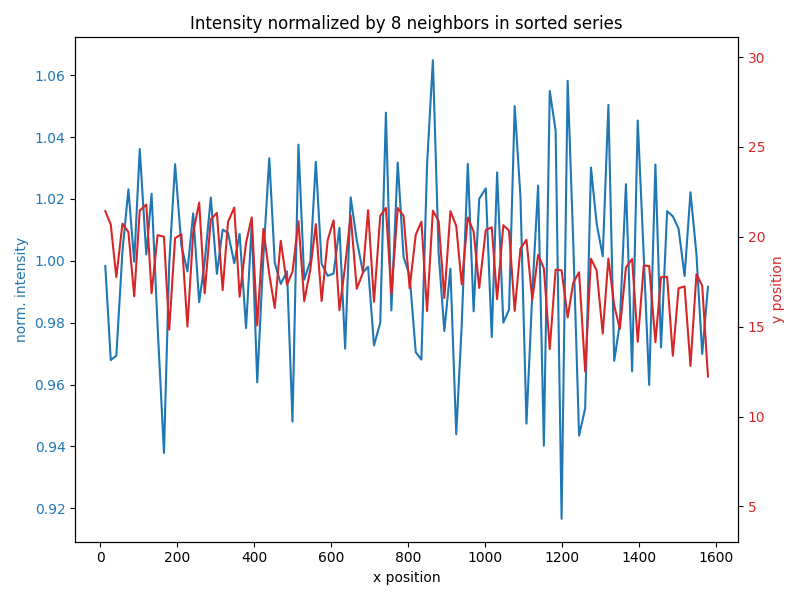

In [ ]:
half = 4
N = len(sums)
norm_sums = np.empty(N)

for i in range(N):
    start = max(0, i - half)
    end   = min(N, i + half + 1)
    window = sums[start:end]

    rel_idx = i - start
    neigh_vals = np.delete(window, rel_idx)

    local_mean = neigh_vals.mean() if neigh_vals.size>0 else np.nan
    norm_sums[i] = sums[i] / local_mean

# now plot norm_sums vs x_loc alongside y_loc
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(x_loc, norm_sums,
         color='tab:blue', label='intensity (9-pt local norm)')
ax1.set_xlabel('x position')
ax1.set_ylabel('norm. intensity', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(x_loc, y_loc,
         color='tab:red', label='y position')
ax2.set_ylabel('y position', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# pad the y2 axis
ymin, ymax = y_loc.min(), y_loc.max()
ax2.set_ylim(ymin - 0.95*(ymax-ymin),
             ymax + 0.95*(ymax-ymin))

plt.title("Intensity normalized by 8 neighbors in sorted series")
fig.tight_layout()
plt.show()
